# Mask a Raster Using Threshold Values in Python
In this tutorial, we will learn how to remove parts of a raster based on pixel values using a mask we create. As an example, we'll use the NEON TEAK CHM and Aspect LiDAR data products, and create a raster containing South Facing pixels where Canopy Height > 20m. 

The graphic below illustrates raster masking.

<img src="http://neonscience.github.io/neon-data-institute-2016/images/spatialData/raster_masks.jpg" style="width: 750px;"/>

## Import LiDAR Data

To start, we will open the NEON LiDAR Digital Surface and Digital Terrain Models (DSM and DTM) which are in Geotiff (.tif) format. For this exercise we will continue working with the TEAK data subset. 

In [1]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

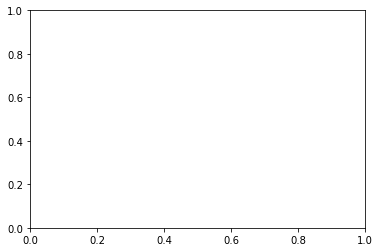

In [2]:
# Define the plot_band_array function from Day 1
def plot_band_array(band_array,refl_extent,colorlimit,ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='spectral'):
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

In [3]:
#%load raster2array

from osgeo import gdal
import numpy as np

def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]
    
    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
        
        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)
        
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==metadata['noDataValue']]=np.nan
        array = array/metadata['scaleFactor']
        array = array[::-1] #inverse array because Python is column major
        return array, metadata
    
    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')

Let's use this function to read in the classified TEAK Aspect raster created in the previous lesson. 

In [4]:
teak_ns_array,teak_ns_md = raster2array('./Outputs/TEAK_NS_Classification.tif')

Plot to check that it looks correct:

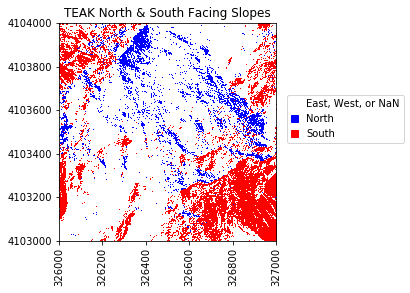

In [5]:
# Plot classified aspect (N-S) array
from matplotlib import colors
fig, ax = plt.subplots()
cmapNS = colors.ListedColormap(['white','blue','red'])
plt.imshow(teak_ns_array,extent=teak_ns_md['extent'],cmap=cmapNS)
plt.title('TEAK North & South Facing Slopes')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

# Create custom legend to label N & S
import matplotlib.patches as mpatches
white_box = mpatches.Patch(color='white',edgecolor='red',label='East, West, or NaN')
blue_box = mpatches.Patch(color='blue', label='North')
red_box = mpatches.Patch(color='red', label='South')
ax.legend(handles=[white_box,blue_box,red_box],handlelength=0.7,bbox_to_anchor=(1.05, 0.45), 
          loc='lower left', borderaxespad=0.)

Now read in the TEAK CHM geotif array using the `raster2array` function from the module:

In [6]:
#Read in TEAK CHM
teak_chm_array,teak_chm_md = raster2array('../data/TEAK/lidar/2013_TEAK_1_326000_4103000_pit_free_CHM.tif')

Display the metadata. To get an idea of the range of canopy height values, look at the bandstats.

In [7]:
for item in sorted(teak_chm_md):
    print(item + ':', teak_chm_md[item])

array_cols: 1000
array_rows: 1000
bands: 1
bandstats: {'mean': 8.84, 'max': 59.96, 'stdev': 11.82, 'min': 0.0}
driver: GeoTIFF
ext_dict: {'yMin': 4103000.0, 'yMax': 4104000.0, 'xMin': 326000.0, 'xMax': 327000.0}
extent: (326000.0, 327000.0, 4103000.0, 4104000.0)
geotransform: (326000.0, 1.0, 0.0, 4104000.0, 0.0, -1.0)
noDataValue: -9999.0
pixelHeight: -1.0
pixelWidth: 1.0
projection: PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32611"]]
scaleFactor: 1.0


To get a better idea of the distribution of the canopy heights, plot a histogram, first removing the zero and NaN values:

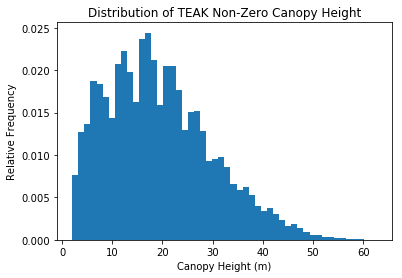

In [8]:
import copy
teak_chm_nonzero = copy.copy(teak_chm_array)
teak_chm_nonzero[teak_chm_array==0]=np.nan
teak_chm_nonzero_nonan = teak_chm_nonzero[~np.isnan(teak_chm_nonzero)]
# Use weighting to plot relative frequency
plt.hist(teak_chm_nonzero_nonan,weights=np.zeros_like(teak_chm_nonzero_nonan)+1./
         (teak_chm_array.shape[0]*teak_chm_array.shape[1]),bins=50);

# plt.hist(chm_nonzero_nonan_array.flatten(),50) 
plt.title('Distribution of TEAK Non-Zero Canopy Height')
plt.xlabel('Canopy Height (m)'); plt.ylabel('Relative Frequency')

Now plot, setting the extent to 60m.

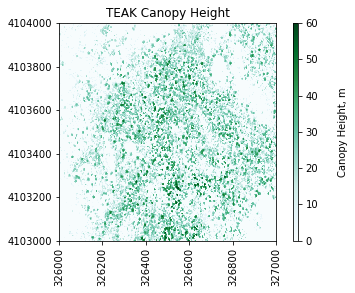

In [9]:
# Plot TEAK CHM
plot_band_array(teak_chm_array,teak_chm_md['extent'],(0,60), \
                title='TEAK Canopy Height',cmap_title='Canopy Height, m',colormap='BuGn')

## Mask Data by Aspect and NDVI
Now that we have imported and converted the TEAK classified aspect and CHM rasters to arrays, we can use information from these to create a new raster consisting of pixels that are South facing and have a canopy height > 20m.

[[ 30.25        29.51000023  29.         ...,          nan          nan
           nan]
 [ 29.37999916  29.19000053  28.39999962 ...,          nan          nan
           nan]
 [ 28.65999985  28.37999916          nan ...,          nan          nan
           nan]
 ..., 
 [         nan          nan          nan ...,          nan          nan
           nan]
 [         nan          nan          nan ...,          nan          nan
           nan]
 [         nan          nan          nan ...,          nan          nan
           nan]]


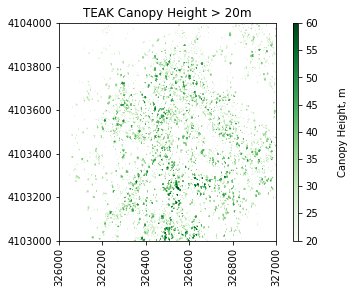

In [10]:
#Create a mask of pixels with CHM < 20m
import numpy.ma as ma

#first copy the chm array so we can further select a subset (need to use copy because arrays are mutable/changeable)
teak_chm_gt20 = copy.copy(teak_chm_array)
teak_chm_gt20[teak_chm_array<20]=np.nan
print(teak_chm_gt20) #display for 

plot_band_array(teak_chm_gt20,teak_chm_md['extent'],(20,60), \
                title='TEAK Canopy Height > 20m',cmap_title='Canopy Height, m',colormap='Greens')

Now include the additional requirement that slope is South-facing (i.e. aspectNS_array = class 2)

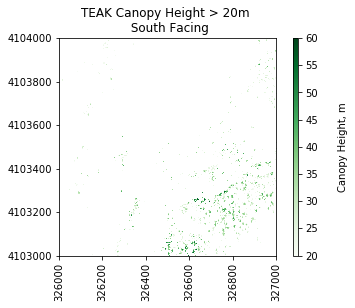

In [11]:
teak_chm_gt20_S = copy.copy(teak_chm_gt20)
teak_chm_gt20_S[teak_ns_array!=2]=np.nan #mask all classes other than 1 (South-facing)

plot_band_array(teak_chm_gt20_S,teak_chm_md['extent'],(20,60), \
                title='TEAK Canopy Height > 20m \n South Facing',cmap_title='Canopy Height, m',colormap='Greens')

# Practice Exercises - On Your Own

## Exercise #1: Export Masked Raster to Geotiff

Use the array2raster function to export this masked raster to a geotiff. Pull it into QGIS to make sure it looks reasonable. 

## Exercise #2: Try out masking with other CHM LiDAR L2 products. 
Choose thresholds for two (or more) of the TEAK LiDAR geotifs (DTM, DSM, CHM, Slope, Aspect) and create a masked raster based on the criteria you chose. First read in the geotifs as arrays and look at the statistics and histograms to choose reasonable threshold values. 